<a href="https://colab.research.google.com/github/Jumas-Cola/Neural_Networks_and_CV/blob/master/PyTorch_numbers_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import random
import numpy as np

def determinate_notebook():
  random.seed(0)
  np.random.seed(0)
  torch.manual_seed(0)
  torch.cuda.manual_seed(0)
  torch.backends.cudnn.deterministic = True

determinate_notebook()

In [2]:
import torchvision.datasets

MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


In [0]:
X_train = MNIST_train.data
y_train = MNIST_train.targets
X_test = MNIST_test.data
y_test = MNIST_test.targets

In [4]:
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [0]:
X_train = X_train.float()
X_test = X_test.float()

In [6]:
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [7]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

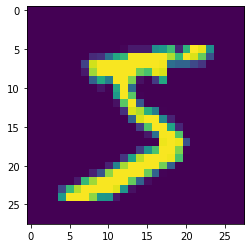

tensor(5)


In [8]:
import matplotlib.pyplot as plt

plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [0]:
X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])

In [0]:
class MNISTNet(torch.nn.Module):
  def __init__(self, n_hidden_neurons):
    super().__init__()
    self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
    self.act1 = torch.nn.Sigmoid()
    self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
    self.act2 = torch.nn.Tanh()
    self.fc3 = torch.nn.Linear(n_hidden_neurons, 10)
  
  def forward(self, x):
    x = self.fc1(x)
    x = self.act1(x)
    x = self.fc2(x)
    x = self.act2(x)
    x = self.fc3(x)
    return x

mnist_net = MNISTNet(100)

In [11]:
!nvidia-smi

Fri Feb 14 15:47:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mnist_net = mnist_net.to(device)
list(mnist_net.parameters())

[Parameter containing:
 tensor([[-0.0003,  0.0192, -0.0294,  ...,  0.0219,  0.0037,  0.0021],
         [-0.0198, -0.0150, -0.0104,  ..., -0.0203, -0.0060, -0.0299],
         [-0.0201,  0.0149, -0.0333,  ..., -0.0203,  0.0012,  0.0080],
         ...,
         [ 0.0221,  0.0258, -0.0088,  ..., -0.0141,  0.0051, -0.0318],
         [-0.0217, -0.0136,  0.0185,  ..., -0.0012, -0.0012, -0.0017],
         [ 0.0142,  0.0089, -0.0053,  ...,  0.0311, -0.0181,  0.0020]],
        device='cuda:0', requires_grad=True), Parameter containing:
 tensor([-3.5402e-02,  1.8178e-02, -2.1709e-02, -1.1839e-02,  4.8722e-03,
         -1.0492e-02, -1.9008e-02,  2.6994e-02, -3.4899e-02,  1.0381e-02,
         -3.5228e-02, -5.6381e-03, -2.0134e-02, -3.0264e-02, -1.3289e-02,
          2.5346e-02, -1.0797e-02,  2.1568e-03,  4.3630e-03, -2.1916e-02,
          2.2670e-02, -1.5766e-02,  3.4906e-02, -2.3063e-02, -6.8216e-03,
          2.7051e-02, -1.3991e-02,  9.7218e-03, -9.9075e-04,  1.6625e-03,
          2.3455e-02, -2

In [0]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-4)

In [14]:
batch_size = 100

train_accuracy_history = []
train_loss_history = []
test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

import time

start_time = time.time()

for epoch in range(50):
  order = np.random.permutation(len(X_train))
  for start_index in range(0, len(X_train), batch_size):
    optimizer.zero_grad()
    batch_indexes = order[start_index:start_index+batch_size]

    X_batch = X_train[batch_indexes].to(device)
    y_batch = y_train[batch_indexes].to(device)

    preds = mnist_net.forward(X_batch)

    loss_value = loss(preds, y_batch)
    loss_value.backward()

    optimizer.step()
  if start_index + batch_size >= len(X_train):
    train_preds = mnist_net.forward(X_batch.cuda())
    train_loss_history.append(loss(train_preds, y_batch.cuda()))

    accuracy = (train_preds.argmax(dim=1) == y_batch.cuda()).float().mean()
    train_accuracy_history.append(accuracy)

  test_preds = mnist_net.forward(X_test)
  test_loss_history.append(loss(test_preds, y_test))

  accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
  test_accuracy_history.append(accuracy)

  print(accuracy)
print(device, time.time() - start_time)
# cuda:0 85.4325487613678
# cpu 203.7979030609131

tensor(0.8898, device='cuda:0')
tensor(0.9142, device='cuda:0')
tensor(0.9258, device='cuda:0')
tensor(0.9337, device='cuda:0')
tensor(0.9362, device='cuda:0')
tensor(0.9422, device='cuda:0')
tensor(0.9435, device='cuda:0')
tensor(0.9475, device='cuda:0')
tensor(0.9498, device='cuda:0')
tensor(0.9517, device='cuda:0')
tensor(0.9516, device='cuda:0')
tensor(0.9519, device='cuda:0')
tensor(0.9552, device='cuda:0')
tensor(0.9540, device='cuda:0')
tensor(0.9540, device='cuda:0')
tensor(0.9583, device='cuda:0')
tensor(0.9560, device='cuda:0')
tensor(0.9591, device='cuda:0')
tensor(0.9591, device='cuda:0')
tensor(0.9587, device='cuda:0')
tensor(0.9571, device='cuda:0')
tensor(0.9580, device='cuda:0')
tensor(0.9630, device='cuda:0')
tensor(0.9635, device='cuda:0')
tensor(0.9620, device='cuda:0')
tensor(0.9621, device='cuda:0')
tensor(0.9602, device='cuda:0')
tensor(0.9641, device='cuda:0')
tensor(0.9607, device='cuda:0')
tensor(0.9607, device='cuda:0')
tensor(0.9625, device='cuda:0')
tensor(0

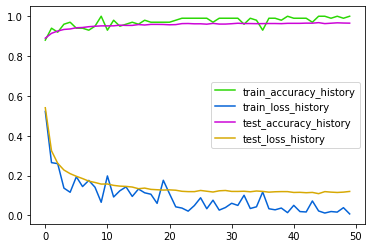

In [15]:
plt.plot(train_accuracy_history, c='#2bd704', label='train_accuracy_history')
plt.plot(train_loss_history, c='#0463d7', label='train_loss_history')
plt.plot(test_accuracy_history, c='#cc04d7', label='test_accuracy_history')
plt.plot(test_loss_history, c='#d7a904', label='test_loss_history')
plt.legend()

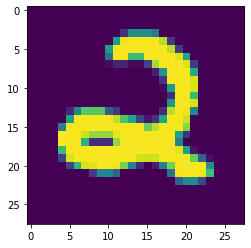

Prediction:  2
Target:  2


In [16]:
item_number = random.randint(0, len(X_test))
plt.imshow(X_test[item_number].reshape(28, 28).cpu())
plt.show()

print('Prediction: ', int(mnist_net.forward(X_test[item_number]).argmax()))
print('Target: ', int(y_test[item_number]))

# Saving Model

In [0]:
# # on collab
# torch.save(mnist_net.cpu(), 'mnist_net')

# # on PC
# import torch
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

# class MNISTNet(torch.nn.Module):
#     def __init__(self, n_hidden_neurons):
#         super().__init__()
#         self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
#         self.act1 = torch.nn.Sigmoid()
#         self.fc2 = torch.nn.Linear(n_hidden_neurons, 10)

#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.act1(x)
#         x = self.fc2(x)
#         return x

# mnist_net = torch.load('mnist_net')

# # палитра изображения - градации серого
# # гамма - линейное пространство
# # формат bmp
# img = mpimg.imread('4.bmp')
# imgplot = plt.imshow(img)
# plt.show()
# print(mnist_net.forward(torch.Tensor(img).reshape(-1, 28 * 28)).argmax())
